### Case Study #1 - Danny's Diner

https://8weeksqlchallenge.com/case-study-1/


<h2> Entity Relationship Diagram </h2>

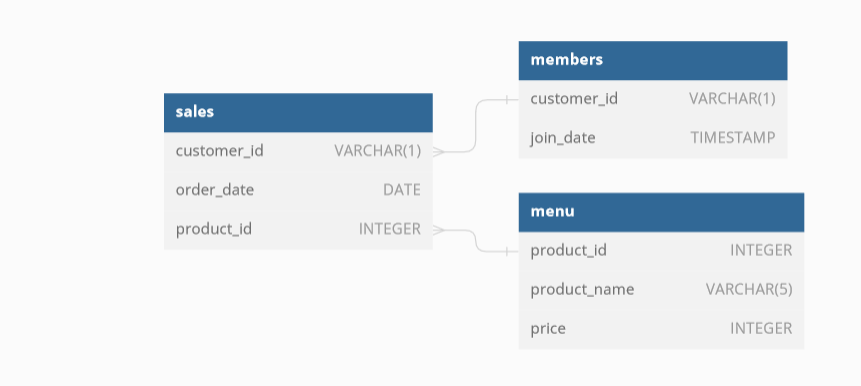

<h2> Case Study Questions </h2>
Each of the following case study questions can be answered using a single SQL statement:

1. What is the total amount each customer spent at the restaurant?
2. How many days has each customer visited the restaurant?
3. What was the first item from the menu purchased by each customer?
4. What is the most purchased item on the menu and how many times was it purchased by all customers?
5. Which item was the most popular for each customer?
6. Which item was purchased first by the customer after they became a member?
7. Which item was purchased just before the customer became a member?
8. What is the total items and amount spent for each member before they became a member?
9. If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?
10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, 
                                   sum,
                                   countDistinct,
                                   to_date,
                                   first,
                                   dense_rank,
                                   count,
                                   when,
                                   date_add,
                                   month
                                  )
from pyspark.sql import Window

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
sales_file_path = 'Data/sales.csv'
menu_file_path = 'Data/menu.csv'
members_file_path = 'Data/members.csv'

In [4]:
df_sales = spark.read.csv(sales_file_path,
                          header=True,
                          inferSchema=True
                         )
df_menu = spark.read.csv(menu_file_path,
                         header=True,
                         inferSchema=True
                        )
df_members = spark.read.csv(members_file_path,
                            header=True,
                            inferSchema=True
                           )

In [5]:
df_sales.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- product_id: integer (nullable = true)



In [6]:
df_menu.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: integer (nullable = true)



In [7]:
df_members.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- join_date: string (nullable = true)



In [8]:
# What is the total amount each customer spent at the restaurant?

(df_sales
 .join(df_menu, on='product_id', how='inner')
 .groupby(col('customer_id'))
#  .agg({'price': 'sum'})
 .agg(sum('price').alias('total_spent'))
 .show()
)

+-----------+-----------+
|customer_id|total_spent|
+-----------+-----------+
|          B|         74|
|          C|         36|
|          A|         76|
+-----------+-----------+



In [9]:
# How many days has each customer visited the restaurant?

(df_sales
 .groupby(col('customer_id'))
 .agg(countDistinct('order_date').alias('total_visits'))
 .show()
)

+-----------+------------+
|customer_id|total_visits|
+-----------+------------+
|          B|           6|
|          C|           2|
|          A|           4|
+-----------+------------+



In [10]:
# What was the first item from the menu purchased by each customer?

window_spec = Window.partitionBy(col('customer_id')).orderBy(col('new_date'))

(df_sales
 .join(df_menu, on='product_id', how='inner')
 .withColumn('new_date', to_date(col('order_date')))
 .withColumn('rank', dense_rank().over(window_spec))
 .where(col('rank') == 1)
 .select(col('customer_id'), col('product_name'))
 .dropDuplicates()
 .show()
)

+-----------+------------+
|customer_id|product_name|
+-----------+------------+
|          A|       sushi|
|          A|       curry|
|          B|       curry|
|          C|       ramen|
+-----------+------------+



In [11]:
# What is the most purchased item on the menu and how many times was it purchased by all customers?

(df_sales
 .join(df_menu, on='product_id', how='inner')
 .groupby('product_name')
 .agg(count(col('product_name')).alias('total_purchase'))
 .sort(col('total_purchase').desc())
 .limit(1)
 .show()
)

+------------+--------------+
|product_name|total_purchase|
+------------+--------------+
|       ramen|             8|
+------------+--------------+



In [12]:
# Which item was the most popular for each customer?

window_spec = Window.partitionBy(col('customer_id'), col('product_id'))

w1 = Window.partitionBy(col('customer_id')).orderBy(col('total').desc())

(df_sales
 .join(df_menu, on='product_id', how='inner')
 .withColumn('total', count('product_id').over(window_spec))
 .withColumn('rank', dense_rank().over(w1))
 .where(col('rank') == 1)
 .select(col('customer_id'), col('product_name'))
 .dropDuplicates()
 .show()
)

+-----------+------------+
|customer_id|product_name|
+-----------+------------+
|          A|       ramen|
|          B|       sushi|
|          B|       curry|
|          B|       ramen|
|          C|       ramen|
+-----------+------------+



In [13]:
# Which item was purchased first by the customer after they became a member?

window_spec = Window.partitionBy(col('customer_id')).orderBy(col('order_date'))

(df_sales
 .join(df_members, on='customer_id', how='inner')
 .withColumn('order_date', to_date(col('order_date')))
 .withColumn('join_date', to_date(col('join_date')))
 .where(col('order_date') >= col('join_date'))
 .withColumn('rnk', dense_rank().over(window_spec))
 .where(col('rnk') == 1)
 .join(df_menu, on='product_id', how='inner')
 .select(col('customer_id'), col('product_name'))
 .show()
)

+-----------+------------+
|customer_id|product_name|
+-----------+------------+
|          A|       curry|
|          B|       sushi|
+-----------+------------+



In [14]:
# Which item was purchased just before the customer became a member?

window_spec = Window.partitionBy(col('customer_id')).orderBy(col('order_date').desc())

(df_sales
 .join(df_members, on='customer_id', how='inner')
 .withColumn('order_date', to_date(col('order_date')))
 .withColumn('join_date', to_date(col('join_date')))
 .where(col('order_date') < col('join_date'))
 .withColumn('rnk', dense_rank().over(window_spec))
 .where(col('rnk') == 1)
 .join(df_menu, on='product_id', how='inner')
 .select(col('customer_id'), col('product_name'))
 .show()
)

+-----------+------------+
|customer_id|product_name|
+-----------+------------+
|          A|       sushi|
|          A|       curry|
|          B|       sushi|
+-----------+------------+



In [15]:
# What is the total items and amount spent for each member before they became a member?
# window_spec = Window.partitionBy(col('customer_id'))

(df_sales
 .join(df_members, on='customer_id', how='inner')
 .join(df_menu, on='product_id', how='inner')
 .withColumn('order_date', to_date(col('order_date')))
 .withColumn('join_date', to_date(col('join_date')))
 .where(col('order_date') < col('join_date'))
 .groupby(col('customer_id'))
 .agg(count(col('product_id')).alias('total_items'), sum(col('price')).alias('total_spent'))
 .show()
)

+-----------+-----------+-----------+
|customer_id|total_items|total_spent|
+-----------+-----------+-----------+
|          B|          3|         40|
|          A|          2|         25|
+-----------+-----------+-----------+



In [16]:
# If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?

window_spec = Window.partitionBy(col('customer_id'))

(df_sales
 .join(df_menu, on='product_id', how='inner')
 .groupby(col('customer_id'))
 .agg(sum(when(col('product_name') == 'sushi', 2 * 10 * col('price'))
          .otherwise(10 * col('price')))
      .alias('total_points'))
 .show()
)

+-----------+------------+
|customer_id|total_points|
+-----------+------------+
|          B|         940|
|          C|         360|
|          A|         860|
+-----------+------------+



In [17]:
# In the first week after a customer joins the program (including their join date) they earn 2x points on all items,
# not just sushi - how many points do customer A and B have at the end of January?

(df_sales
 .join(df_members, on='customer_id', how='inner')
 .withColumn('order_date', to_date(col('order_date')))
 .withColumn('join_date', to_date(col('join_date')))
 .join(df_menu, on='product_id', how='inner')
 .where(month(col('order_date')) == 1)
 .groupby(col('customer_id'))
 .agg(sum(when(col('product_name') == 'sushi', 2 * 10 * col('price'))
          .when(((col('join_date') <= col('order_date')) & (col('order_date') <= date_add(col('join_date'), 6))), 2 * 10 * col('price'))
          .otherwise(10 * col('price')))
      .alias('total_points')
     )
 .show()
)

+-----------+------------+
|customer_id|total_points|
+-----------+------------+
|          B|         820|
|          A|        1370|
+-----------+------------+



In [18]:
# Join all things

(df_sales
 .join(df_menu, on='product_id', how='inner')
 .join(df_members, on='customer_id', how='left')
 .withColumn('order_date', to_date(col('order_date')))
 .withColumn('join_date', to_date(col('join_date')))
 .withColumn('member', when(col('order_date') >= col('join_date'), 'Y').otherwise('N'))
 .select(col('customer_id'), col('product_name'), col('order_date'), col('price'), col('member'))
 .show()
)

+-----------+------------+----------+-----+------+
|customer_id|product_name|order_date|price|member|
+-----------+------------+----------+-----+------+
|          A|       sushi|2021-01-01|   10|     N|
|          A|       curry|2021-01-01|   15|     N|
|          A|       curry|2021-01-07|   15|     Y|
|          A|       ramen|2021-01-10|   12|     Y|
|          A|       ramen|2021-01-11|   12|     Y|
|          A|       ramen|2021-01-11|   12|     Y|
|          B|       curry|2021-01-01|   15|     N|
|          B|       curry|2021-01-02|   15|     N|
|          B|       sushi|2021-01-04|   10|     N|
|          B|       sushi|2021-01-11|   10|     Y|
|          B|       ramen|2021-01-16|   12|     Y|
|          B|       ramen|2021-02-01|   12|     Y|
|          C|       ramen|2021-01-01|   12|     N|
|          C|       ramen|2021-01-01|   12|     N|
|          C|       ramen|2021-01-07|   12|     N|
+-----------+------------+----------+-----+------+



In [19]:
# Rank all things

window_spec = Window.partitionBy(col('customer_id'), col('member')).orderBy('order_date')

(df_sales
 .join(df_menu, on='product_id', how='inner')
 .join(df_members, on='customer_id', how='left')
 .withColumn('order_date', to_date(col('order_date')))
 .withColumn('join_date', to_date(col('join_date')))
 .withColumn('member', when(col('order_date') >= col('join_date'), 'Y').otherwise('N'))
 .withColumn('rank', when(col('member') == 'Y', dense_rank().over(window_spec)).otherwise(None))
 .select(col('customer_id'), col('product_name'), col('order_date'), col('price'), col('member'), col('rank'))
 .show()
)

+-----------+------------+----------+-----+------+----+
|customer_id|product_name|order_date|price|member|rank|
+-----------+------------+----------+-----+------+----+
|          A|       sushi|2021-01-01|   10|     N|null|
|          A|       curry|2021-01-01|   15|     N|null|
|          A|       curry|2021-01-07|   15|     Y|   1|
|          A|       ramen|2021-01-10|   12|     Y|   2|
|          A|       ramen|2021-01-11|   12|     Y|   3|
|          A|       ramen|2021-01-11|   12|     Y|   3|
|          B|       curry|2021-01-01|   15|     N|null|
|          B|       curry|2021-01-02|   15|     N|null|
|          B|       sushi|2021-01-04|   10|     N|null|
|          B|       sushi|2021-01-11|   10|     Y|   1|
|          B|       ramen|2021-01-16|   12|     Y|   2|
|          B|       ramen|2021-02-01|   12|     Y|   3|
|          C|       ramen|2021-01-01|   12|     N|null|
|          C|       ramen|2021-01-01|   12|     N|null|
|          C|       ramen|2021-01-07|   12|     